# lookup table

Las transformaciones de dominio se pueden implementar mediante una "tabla de acceso" a los pixels.

In [1]:
import numpy             as np
import cv2               as cv
import skimage.io        as io
import matplotlib.pyplot as plt

%matplotlib inline

(450, 728, 3)


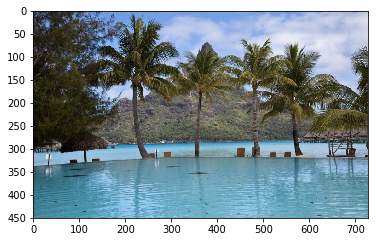

In [2]:
path = "http://robot.inf.um.es/material/va/images/"

img = io.imread(path+"palmeras.jpg")
print(img.shape)
r,c,_ = img.shape
plt.imshow(img);

In [3]:
y,x = np.mgrid[0:r,0:c]

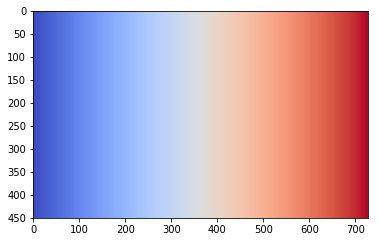

In [4]:
plt.imshow(x,'coolwarm');

In [5]:
fondo =  np.array([160,128,128])
img[0,:]  = fondo
img[-1,:] = fondo
img[:,0]  = fondo
img[:,-1] = fondo

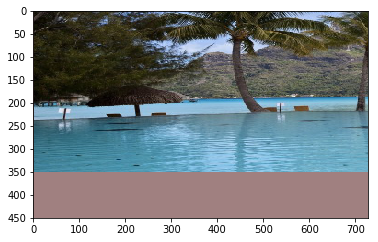

In [6]:
xp = x/2
yp = y+100

t = img[np.clip(yp.astype(int),0,r-1),np.clip(xp.astype(int),0,c-1)]

plt.imshow(t);

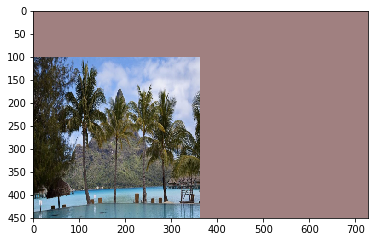

In [7]:
t = img.copy()
t[:] = fondo

xp = x/2
yp = y+100

#t = img[np.clip(yp.astype(int),0,r-1),np.clip(xp.astype(int),0,c-1)]
t[np.clip(yp.astype(int),0,r-1),np.clip(xp.astype(int),0,c-1)] = img

plt.imshow(t);

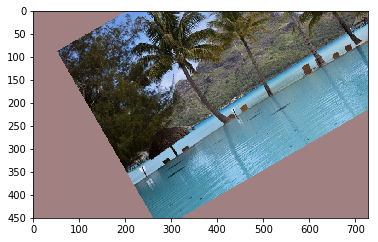

In [8]:
ang = np.radians(30)
xp = np.cos(ang)*x - np.sin(ang)*y
yp = np.sin(ang)*x + np.cos(ang)*y - 100

t = img[np.clip(yp.astype(int),0,r-1),np.clip(xp.astype(int),0,c-1)]

plt.imshow(t);

Muchas transformaciones importantes (rotaciones y otras que estudiaremos más adelante) pueden hacerse mediante funciones de opencv. La ventaja de esta técnica es que nos permite aplicar cualquier deformación:

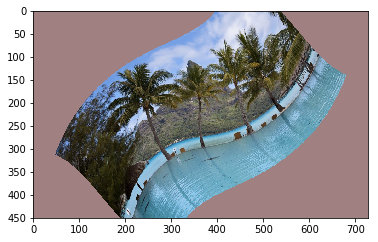

In [9]:
R = np.sqrt((x-c/2)**2 + (y-r/2)**2)
ang = R/400
xp = (np.cos(ang)*(x-c/2) - np.sin(ang)*(y-r/2))*1.3 + c/2
yp = (np.sin(ang)*(x-c/2) + np.cos(ang)*(y-r/2))*1.3 + r/2

t = img[np.clip(yp.astype(int),0,r-1),np.clip(xp.astype(int),0,c-1)]

plt.imshow(t);
#io.imsave('trans.png',t)

Una transformación importante es la eliminación de distorsión radial. La siguiente imagen está tomada de [esta página](https://onlinephotoinstitute.wordpress.com/tag/distortion/) que muestra la distorsión de varias lentes.

(900, 1359, 3)


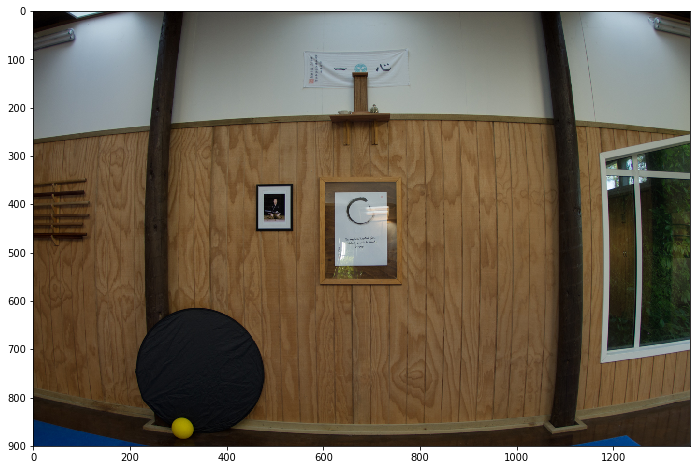

In [10]:
img = io.imread(path+"fisheye-test-7265.jpg")
print(img.shape)
r,c,_ = img.shape
plt.rc('figure',figsize=(12,8))
plt.imshow(img);

Podemos intentar algo parecido con la técnica de tabla de acceso que hemos visto. Un modelo de compensación de distorsión radial muy simple es:

$$ x' = o_x + (x-o_x) \left[ 1 + k r^2 \right] $$

$$ y' = o_y + (y-o_y) \left[ 1 + k r^2 \right] $$

donde $(o_x,o_y)$ es el "centro de distorsión" y $\;r^2 = (x-o_x)^2 + (y-o_y)^2$. Se hace un pequeño desplazamiento de cada pixel en dirección al centro de distorsión.



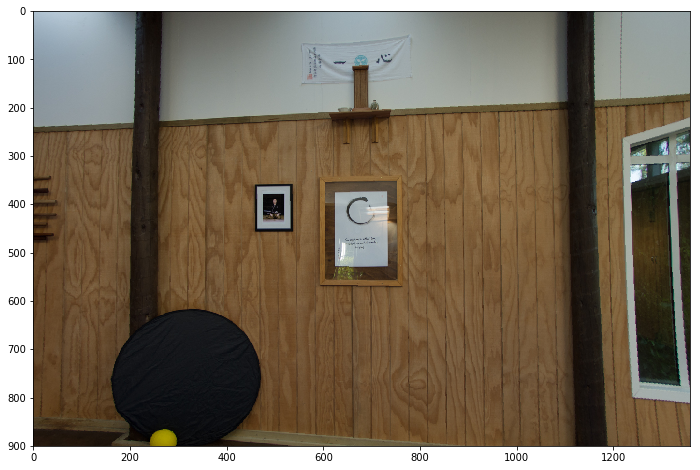

In [11]:
y,x = np.mgrid[0:r,0:c]

ox = c/2
oy = r/2

k = -0.00000027
xp = ox + (x-ox)*(1+ ((x-ox)**2 + (y-oy)**2)*k)
yp = oy + (y-oy)*(1+ ((x-oy)**2 + (y-oy)**2)*k)

t = img[np.clip(yp.astype(int),0,r-1),np.clip(xp.astype(int),0,c-1)]

plt.imshow(t);

El coeficiente $k$ lo hemos puesto por prueba y error hasta que las columnas están bastante rectas. No queda mal del todo pero es mejor utilizar OpenCV.

La corregimos con valores a ojo de la matriz de calibración (que estudiaremos más adelante) y el coeficiente de distorsión radial. En el resultado podemos cambiar el campo de visión de la imagen con una matriz de calibración distinta para quitar las zonas negras y consegir una región rectangular completa.

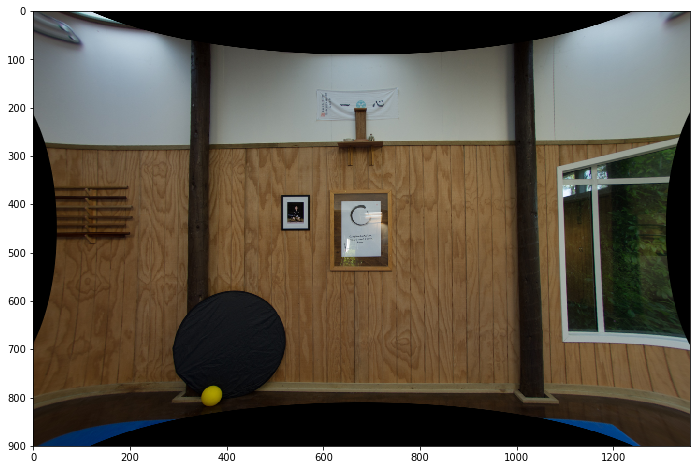

In [12]:
def kgen(sz,f):
    w,h = sz
    w2 = w / 2
    h2 = h / 2
    return np.array([[f*w2,0,   w2],
                     [0,  f*w2, h2],
                     [0,   0,   1 ]])


K  = kgen((c,r),2)
#KN = K
KN = kgen((c,r),1.5)

plt.imshow(cv.undistort(img,K,np.array([-0.5,0,0,0,0]),None,KN)); 

Por supuesto, la forma correcta de hacerlo es aplicar el método de calibración basado en varias imágenes de un *chessboard* que estudiaremos en un capítulo posterior.

El modelo de `cv.undistort` no funciona muy bien con las distorsiones tremendas de las cámaras wide-angle (tipo go pro). Afortunadamente OpenCV incluye nuevas funciones de calibración de para este tipo de cámaras: [pyfisheye](https://bitbucket.org/amitibo/pyfisheye).